# Import Dependencies

In [2]:
import requests as req
import pandas as pd
import numpy as np
import math

import scipy.sparse as sparse
import implicit
from sklearn.preprocessing import MinMaxScaler

import ast
import pprint

from tqdm import tqdm

# Data Collection
The cells below will follow a series of steps to collect data about our users and Anime content.

## Kitsu API

Kitsu is a modern anime discovery platform that helps you track the anime you're watching, discover new anime and socialize with other fans.

Within the Kitsu API __https://kitsu.docs.apiary.io/__ -- it contains data pertaining to users and the anime they have watched, rated, liked, commented, and overall have interacted with.

In the next few cells we will aim to pull a initial sample of ~500 users and their interaction data.

In total, there are 1,182,501 users and through the API, we are able to traverse through 20 results at a time. If we traverse through all 1.1M users only 20 at a time, we will need to make 59,125 iterations. 

For MVP purposes, we will pull a sample of 5,000 random users only needing 250 iterations.

To randomly select the 5,000 users knowing we can pull 20 from a page at a time -- we will use the following code to select for those users.

In [3]:
num_users = 1182501
sample_n = 5000
users_per_page = 20
pages_n = int(sample_n / users_per_page)

# Increment the pages
pages_array = np.arange(0,num_users,pages_n)

# Shuffle the array of pages
np.random.shuffle(pages_array)

# Get the first pages_n from pages_array
pages_to_query = pages_array[:pages_n]

print(f'The pages to iterate through: {pages_n} \nThe number of users data to collect: {pages_n*users_per_page}')

The pages to iterate through: 250 
The number of users data to collect: 5000


In [4]:
# Create users dict to collect data
users_dict = {'id':[],
              'name':[],
              'location':[],
              'createdAt':[],
              'lifeSpentOnAnime':[],
              'followersCount':[],
              'followingCount':[],
              'birthday':[],
              'commentsCount':[],
              'favoritesCount':[],
              'likesGivenCount':[],
              'reviewsCount':[],
              'likesReceivedCount':[],
              'postsCount':[],
              'ratingsCount':[],
              'likesReceivedCount':[],
              'proTier':[],
              'relationships':[]}

## Iterate through pages of the Kitsu API to retrieve user data

In [4]:
# Create list of keys to later iterate through 
data_extract = list(users_dict.keys())
data_extract.remove('id')
data_extract.remove('relationships')

# Set up link to iterate through
for page_num in tqdm(pages_to_query):
# for page_num in [20]:
    
    # Set up link to retrieve response from
    kitsu_link = f"https://kitsu.io/api/edge/users?page%5Blimit%5D=20&page%5Boffset%5D={page_num}"

    # Retrieve response
    response = req.get(kitsu_link)
    data = response.json()

    # Iterate through 'data' list in json API response
    for user in data['data']:
        
        # Retrieve desired data points
        attr = user['attributes']
        user_id = user['id']
        rel = user['relationships']
        
        users_dict['id'].append(user_id)
        users_dict['relationships'].append(rel)
        
        # Iterate through users_dict keys for particular data points of interest
        for key in data_extract:
            users_dict[key].append(attr.get(key, np.nan))

100%|██████████| 250/250 [11:02<00:00,  2.65s/it]


In [5]:
# convert users_dict to a dataframe
animeUsers_df = pd.DataFrame(users_dict)

# Save to csv
# animeUsers_df.to_csv('animeUsers.csv',index=False)

In [5]:
animeUsers_df = pd.read_csv('animeUsers.csv')

In [6]:
# Peek at data
animeUsers_df.head()

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships
0,717575,ybicona,Baltimore,2020-04-29T16:36:29.021Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
1,717576,skgsudhirkumar,NaN,2020-04-29T16:36:35.763Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2,717577,βαγγέλης_μαχαίρας,NaN,2020-04-29T16:37:05.758Z,0,0,0,NaN,0,0,0,0,0,0,12,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3,717578,Mame,NaN,2020-04-29T16:37:44.164Z,0,0,0,NaN,0,0,0,0,0,0,5,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
4,717579,ryan_maulana,NaN,2020-04-29T16:38:07.323Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...


In [7]:
animeUsers_df.sort_values('favoritesCount',ascending=False).head(10)

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships
979,85539,maria12021,Norway,2015-04-06T00:55:29.333Z,74217,4,2,2001-04-18,0,209,0,0,0,0,605,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2754,143115,Liv_Martin_Strong,UK,2017-01-16T01:03:19.919Z,0,36,28,1991-08-14,44,139,26,27,30,33,280,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3747,121938,70a573r,The Government,2016-03-20T23:46:32.451Z,20854,6,2,2001-09-11,2,86,4,1,7,3,5,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3971,70211,LadyGira,Pirate Ship,2014-12-09T04:44:12.856Z,451853,5,10,NaN,0,82,10,0,1,0,1040,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2523,86869,nick_gooeygrass,NaN,2015-04-15T23:18:46.962Z,73828,1,1,NaN,0,55,0,0,0,0,96,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2149,78730,Iago,South,2015-02-07T13:48:55.698Z,137029,69,61,NaN,6,51,986,0,-9,3,655,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2487,561112,kevintombs20,NaN,2019-08-13T18:19:22.094Z,0,0,0,NaN,0,46,0,0,0,0,71,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
4833,100364,Wolfwood93,Colorado,2015-08-08T17:34:30.626Z,96306,15,6,1993-09-13,2,44,14,0,-2,-1,178,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
119,278590,BarretKun,"São Bernardo do Campo, SP, Brazil",2018-05-29T16:05:06.030Z,0,1,1,1999-06-24,0,41,0,0,0,0,172,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
1970,582074,Legorion,"Latvia,Riga",2019-09-22T15:42:08.578Z,0,4,5,1986-09-22,1,39,3,0,0,0,37,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...


commentsCount        2178
favoritesCount       4178
likesGivenCount      5689
reviewsCount          100
postsCount            920
ratingsCount       135568
dtype: int64



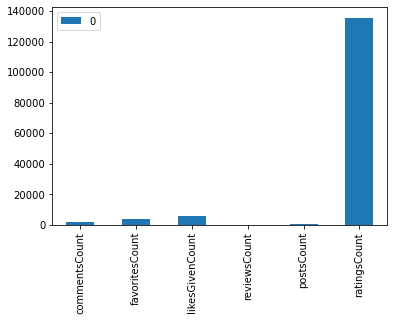

In [8]:
# Examine distribution of interaction types among users
interaction_list = ['commentsCount',
                    'favoritesCount', 
                    'likesGivenCount', 
                    'reviewsCount',
                    'postsCount', 
                    'ratingsCount']

print(animeUsers_df[interaction_list].sum())
print()

pd.DataFrame(animeUsers_df[interaction_list].sum()).plot(kind='bar');

- favorites
- reviews
    - https://kitsu.io/api/edge/users/22/reviews; reviews id; https://kitsu.io/api/edge/reviews/review id/media

In [9]:
# Peek at few examples of relationships column
jt = ast.literal_eval(animeUsers_df['relationships'][1])
jt2 = ast.literal_eval(animeUsers_df['relationships'][4])

In [17]:
get_kitsu_response( jt2['favorites']['links']['related'] )

{'data': [],
 'meta': {'count': 0},
 'links': {'first': 'https://kitsu.io/api/edge/users/717579/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0',
  'last': 'https://kitsu.io/api/edge/users/717579/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0'}}

In [16]:
def get_kitsu_response(link):
    """
    Returns a pretty printed response from JSON object
    
    Parameters
    ----------
    link : str
        The URL to query from Kitsu API

    Returns
    -------
    pretty printed view of json response
    
    """
    kitsu_response = req.get(link)
    kitsu_data = kitsu_response.json()
    return kitsu_data

## Retrieve Favorite Anime per User

In [11]:
def get_user_favorites(user_id):
    """
    Returns a list of a user's favorite anime
    
    Parameters
    ----------
    user_id : int
        user_id
    Returns
    -------
    Dictionary of the user's favorited anime
    
    """
    print(f'Retrieving favorites data for user {user_id}')
    kitsu_link = f'https://kitsu.io/api/edge/favorites/?filter[userId]={user_id}&[itemType]=Media'
    kitsu_response = req.get(kitsu_link)
    kitsu_data = kitsu_response.json()

    # Store favorites dictionary
    fav_dict = {'user_id':None,
                'anime_id':[],
                'canonicalTitle':[],
                'synopsis':[],
                'description':[]}
    
    # Check for number of favorites -- if more than 10; paginate through all favorites else retrieve favorites on page
    favorites_count = kitsu_data['meta']['count']
        
    pages = math.floor((favorites_count/10)+1)
    page_nums = []
    count = 0
    # Create list of pages to paginate through
    for num in range(pages):
        page_nums.append(num*10)
       
    # Retrieve data from each page
    for page in tqdm(page_nums):
        link = f'https://kitsu.io/api/edge/favorites?filter%5BuserId%5D={user_id}&page%5Blimit%5D=10&page%5Boffset%5D={page}'
        fav_page = get_kitsu_response(link)
        for fav in fav_page['data']:
            
            # Get link to retrieve anime data
            item = fav['relationships']['item']['links']['related']
            anime_response = get_kitsu_response(item)
            
            # Check that the user's marked favorite is an anime
            if anime_response['data']['type'] == 'anime':
                
                title = anime_response['data']['attributes'].get('canonicalTitle', np.nan)
                anime_id = anime_response['data'].get('id', np.nan)
                synopsis = anime_response['data']['attributes'].get('synopsis', np.nan)
                desc = anime_response['data']['attributes'].get('description', np.nan)

                fav_dict['anime_id'].append(anime_id)
                fav_dict['canonicalTitle'].append(title)
                fav_dict['synopsis'].append(synopsis)
                fav_dict['description'].append(desc)
                count += 1
                
            # If the marked favorite is not an anime --> skip
            else:
                continue
    
    # Create a list of the users_id to map every item to the user
    user_id_list = [user_id]*count
    fav_dict['user_id'] = user_id_list
    
    return fav_dict 

## Retrieve Library Entries per User

In [18]:
def get_user_library_entries(user_id):
    """
    Returns a list of a user's library entries. 
    The output of this function will detail anime the user has watched, planned to watch, or stopped watching.
    
    Parameters
    ----------
    user_id : int
        user_id
    Returns
    -------
    Dictionary of the anime a user has interacted with.
    
    """
    print(f'Retrieving library entry data for user {user_id}')
    kitsu_link = f'https://kitsu.io/api/edge/library-entries/?filter[userId]={user_id}&[kind]=anime'
    kitsu_response = req.get(kitsu_link)
    kitsu_data = kitsu_response.json()

    # Store favorites dictionary
    lib_entry_dict = {'user_id':None,
                      'anime_id':[],
                      'status':[],
                      'progress':[],
                      'progressedAt':[],
                      'startedAt':[],
                      'finishedAt':[],
                      'canonicalTitle':[],
                      'synopsis':[],
                      'description':[]}
    
    # Check for number of favorites -- if more than 10; paginate through all favorites else retrieve favorites on page
    entries_count = kitsu_data['meta']['count']
        
    pages = math.floor((entries_count/10)+1)
    page_nums = []
    count = 0
    # Create list of pages to paginate through
    for num in range(pages):
        page_nums.append(num*10)
       
    # Retrieve data from each page
    for page in tqdm(page_nums[:5]):
        link = f'https://kitsu.io/api/edge/library-entries?filter%5BuserId%5D={user_id}&page%5Blimit%5D=10&page%5Boffset%5D={page}'
        le_page = get_kitsu_response(link)
        for le in le_page['data']:
            
            # Retrieve watch status data
            attr = le['attributes']
            status = attr['status']
            progress = attr['progress']
            progressedAt = attr['progressedAt']
            startedAt = attr['startedAt']
            finishedAt = attr['finishedAt']
            
            # Get link to retrieve anime data
            item = le['relationships']['anime']['links']['related']
            anime_response = get_kitsu_response(item)
            try:
                title = anime_response['data']['attributes'].get('canonicalTitle', np.nan)
                anime_id = anime_response['data'].get('id', np.nan)
                synopsis = anime_response['data']['attributes'].get('synopsis', np.nan)
                desc = anime_response['data']['attributes'].get('description', np.nan)
                
                lib_entry_dict['status'].append(status)
                lib_entry_dict['progress'].append(progress)
                lib_entry_dict['progressedAt'].append(progressedAt)
                lib_entry_dict['startedAt'].append(progressedAt)
                lib_entry_dict['finishedAt'].append(finishedAt)
                lib_entry_dict['anime_id'].append(anime_id)
                lib_entry_dict['canonicalTitle'].append(title)
                lib_entry_dict['synopsis'].append(synopsis)
                lib_entry_dict['description'].append(desc)
                count += 1
            except TypeError:
                continue
    
    # Create a list of the users_id to map every item to the user
    user_id_list = [user_id]*count
    lib_entry_dict['user_id'] = user_id_list
    
    return lib_entry_dict 

# Run retrieval functions for a sample of users

In [19]:
user_sample_list = [85539, 143115, 121938, 70211, 86869]

In [20]:
# Retrieve sample of favorites data per user
users_favs_df = pd.DataFrame()

for user in user_sample_list:
    df = pd.DataFrame(get_user_favorites(user))
    users_favs_df = users_favs_df.append(df)

Retrieving favorites data for user 85539


  0%|          | 0/14 [00:00<?, ?it/s]

Retrieving favorites data for user 143115


  0%|          | 0/9 [00:00<?, ?it/s]

Retrieving favorites data for user 121938


  0%|          | 0/9 [00:00<?, ?it/s]

Retrieving favorites data for user 70211


100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


Retrieving favorites data for user 86869


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


In [21]:
users_favs_df.to_csv('animeFavorites_data.csv',index=False)

In [22]:
# Retrieve sample of library entries data per user
users_le_df = pd.DataFrame()

for user in user_sample_list:
    df = pd.DataFrame(get_user_library_entries(user))
    users_le_df = users_le_df.append(df)

Retrieving library entry data for user 85539


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Retrieving library entry data for user 143115


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Retrieving library entry data for user 121938


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Retrieving library entry data for user 70211


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Retrieving library entry data for user 86869


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


In [23]:
users_le_df.to_csv('animeWatchStatus_data.csv',index=False)

In [24]:
users_le_df.head()

,user_id,anime_id,status,progress,progressedAt,startedAt,finishedAt,canonicalTitle,synopsis,description
0,85539,176,completed,1,2016-04-05T21:53:57.987Z,2016-04-05T21:53:57.987Z,2016-04-05T00:00:00.000Z,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih..."
1,85539,6711,completed,1,2015-11-07T21:02:56.128Z,2015-11-07T21:02:56.128Z,2015-11-07T00:00:00.000Z,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in..."
2,85539,142,completed,1,2016-04-05T21:54:13.337Z,2016-04-05T21:54:13.337Z,2016-04-05T00:00:00.000Z,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...
3,85539,8403,completed,22,2015-04-06T00:57:29.294Z,2015-04-06T00:57:29.294Z,2015-04-06T00:00:00.000Z,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...
4,85539,8147,completed,24,2017-04-14T04:09:37.510Z,2017-04-14T04:09:37.510Z,2017-04-14T00:00:00.000Z,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien..."


# Data Processing to set up Recommender Model

In [25]:
# Create status column to align and later combine with users_le_df
# 'favorite' will be used as an event type
users_favs_df['status'] = 'favorite'

In [26]:
users_favs_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status
0,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,favorite
1,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",favorite
2,85539,6836,Tsuritama,Yuki Sanada is a socially awkward young man wh...,Yuki Sanada is a socially awkward young man wh...,favorite
3,85539,8333,Gugure! Kokkuri-san,"Kohina Ichimatsu, the self-proclaimed doll, ca...","Kohina Ichimatsu, the self-proclaimed doll, ca...",favorite
4,85539,5981,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,Jinta Yadomi is peacefully living as a recluse...,Jinta Yadomi is peacefully living as a recluse...,favorite


In [27]:
print(users_favs_df.shape)
print(users_le_df.shape)

(306, 6)
(239, 10)


In [28]:
users_le_df.columns

Index(['user_id', 'anime_id', 'status', 'progress', 'progressedAt',
       'startedAt', 'finishedAt', 'canonicalTitle', 'synopsis', 'description'],
      dtype='object')

In [29]:
list(users_favs_df.columns)

['user_id', 'anime_id', 'canonicalTitle', 'synopsis', 'description', 'status']

In [30]:
# Set columns between both dataframes to be equal for combining
col_list = list(users_favs_df.columns)

users_le_df_append = users_le_df.copy()

users_le_df_append = users_le_df_append[col_list]

user_interaction_df = users_le_df_append.append(users_favs_df, ignore_index=True)

user_interaction_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status
0,85539,176,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih...",completed
1,85539,6711,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in...",completed
2,85539,142,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...,completed
3,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,completed
4,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",completed


Below we will assign an arbitrary event strength for the type of interactions users have had with certain types of anime. 

In [31]:
# Set up event strength dict to assign arbitrary strength score towards interaction types
event_strength = {
    'completed':6.0,
    'favorite':5.0,
    'current':4.0,
    'planned':3.0,
    'on_hold':2.0,
    'dropped':1.0
}

In [32]:
# Map event strength scores according to status set in user_interaction_df
user_interaction_df['eventStrength'] = user_interaction_df['status'].apply(lambda x: event_strength[x])

In [33]:
# Peek at data
user_interaction_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status,eventStrength
0,85539,176,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih...",completed,6.0
1,85539,6711,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in...",completed,6.0
2,85539,142,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...,completed,6.0
3,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,completed,6.0
4,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",completed,6.0


In [34]:
grouped_df = user_interaction_df.groupby(['user_id', 'anime_id', 'canonicalTitle'])['eventStrength'].sum().reset_index()
grouped_df.sample(10)

,user_id,anime_id,canonicalTitle,eventStrength
7,70211,1219,Case Closed: The Phantom of Baker Street,6.0
133,85539,10877,Ansatsu Kyoushitsu 2nd Season,5.0
424,143115,11469,Boku no Hero Academia,6.0
318,86869,6726,Jormungand,11.0
282,86869,10029,Rokka no Yuusha,6.0
323,86869,7245,Kotoura-san,6.0
49,70211,4989,Gintama: The Movie,5.0
350,86869,8409,Garo: Honoo no Kokuin,5.0
388,121938,5389,Squid Girl,3.0
116,70211,923,Sennen Joyuu,5.0


# Fit Alternating Least Squares Model

In [49]:
grouped_df['canonicalTitle'] = grouped_df['canonicalTitle'].astype("category")
grouped_df['user_id'] = grouped_df['user_id'].astype("category")
grouped_df['anime_id'] = grouped_df['anime_id'].astype("category")
grouped_df['person_id'] = grouped_df['user_id'].cat.codes
grouped_df['content_id'] = grouped_df['anime_id'].cat.codes

sparse_content_person = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_content = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

In [50]:
grouped_df.sample(10)

,user_id,anime_id,canonicalTitle,eventStrength,person_id,content_id
411,121938,8271,Tokyo Ghoul,6.0,3,334
130,85539,10740,One Punch Man,5.0,1,22
273,85539,8644,Gakkou Gurashi!,5.0,1,357
158,85539,11939,Fune wo Amu,5.0,1,58
277,85539,8735,Kyoukai no Kanata Movie 1: I'll Be Here - Kako...,3.0,1,366
214,85539,6146,Jinrui wa Suitai Shimashita,5.0,1,204
15,70211,1415,Code Geass: Lelouch of the Rebellion,6.0,0,88
464,143115,7960,Batman Beyond: Return of the Joker,5.0,4,307
207,85539,5646,Steins;Gate,2.0,1,190
89,70211,7664,Free!,11.0,0,280


In [51]:
content_id = 220
n_similar = 10

person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

scores = content_vecs.dot(content_vecs[content_id]) / content_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

for content in similar:
    idx, score = content
    print(grouped_df.canonicalTitle.loc[grouped_df.content_id == idx].iloc[0])

Sword Art Online
Gangsta.
The Devil is a Part-Timer!
Strike the Blood
Toradora!
Nausicaä of the Valley of the Wind
Chuunibyou demo Koi ga Shitai!
Yuri!!! on Ice
Mahou Shoujo Madoka★Magica
Majo no Takkyuubin


In [53]:
def recommend(person_id, sparse_person_content, person_vecs, content_vecs, num_contents=10):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_person_content[person_id,:].toarray()
    # Add 1 to everything, so that articles with no interaction yet become equal to 1
    person_interactions = person_interactions.reshape(-1) + 1
    # Make articles already interacted zero
    person_interactions[person_interactions > 1] = 0
    # Get dot product of person vector and all content vectors
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    # Start empty list to store titles and scores
    titles = []
    scores = []

    for idx in content_idx:
        # Append titles and scores to the list
        titles.append(grouped_df.canonicalTitle.loc[grouped_df.content_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'title': titles, 'score': scores})

    return recommendations
    
# Get the trained person and content vectors. We convert them to csr matrices
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for person with id 50
person_id = 1

recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)

print(recommendations)

                                               title     score
0                         The Devil is a Part-Timer!  0.005232
1                                          Fate/Zero  0.005151
2                                        Summer Wars  0.005110
3                                       Angel Beats!  0.005062
4                                   Strike the Blood  0.004966
5                     Baka to Test to Shoukanjuu Ni!  0.004962
6  Danganronpa: Kibou no Gakuen to Zetsubou no Ko...  0.004941
7                                          Toradora!  0.004824
8                   Fullmetal Alchemist: Brotherhood  0.003884
9                                    No Game No Life  0.003451
